In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import numpy as np
from tcvae import predict, dataset, localconfig
from tcvae.compute_measures import heuristic_names
from matplotlib import pyplot as plt
from IPython.display import Audio
plt.style.use("dark_background")

In [2]:
conf = localconfig.LocalConfig()
conf.load_config_from_file("checkpoints/Default_cnn_decoder_heuristics.json")
conf.dataset_dir = "complete_dataset"
conf.batch_size = 1

_, _, test = dataset.get_dataset(conf)
test_iter = iter(test)

In [3]:
_model = predict.load_model(conf, "checkpoints/27_cnn_decoder_heuristics_0.1883.h5")

Creating Decoder


In [4]:
batch = next(test_iter)

In [5]:
heuristic_names

['inharmonicity',
 'even_odd',
 'sparse_rich',
 'attack_rms',
 'decay_rms',
 'attack_time',
 'decay_time',
 'bass',
 'mid',
 'high_mid',
 'high']

In [7]:
(f0_shifts_true, f0_shifts_pred, mag_env_true, mag_env_pred,
     h_freq_shifts_true, h_freq_shifts_pred, h_mag_dist_true,
     h_mag_dist_pred, mask), note_number_orig = predict.get_intermediate_values(
    _model, batch, conf)

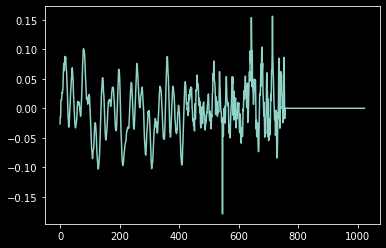

In [8]:
plt.plot(f0_shifts_true[0]);

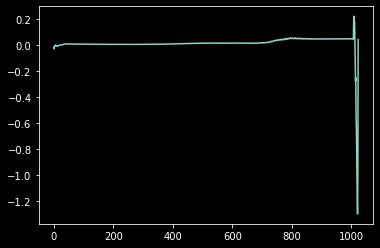

In [9]:
plt.plot(f0_shifts_pred[0]);

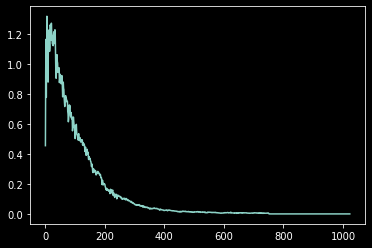

In [10]:
plt.plot(mag_env_true[0]);

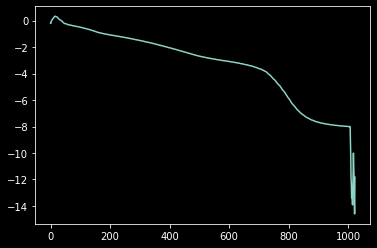

In [11]:
plt.plot(mag_env_pred[0]);

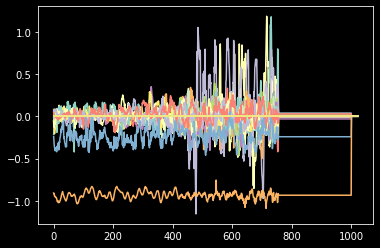

In [12]:
plt.plot(h_freq_shifts_true[0]);

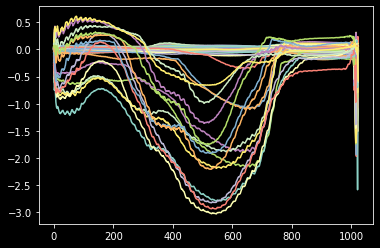

In [13]:
plt.plot(h_freq_shifts_pred[0]);

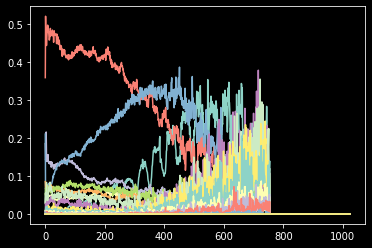

In [14]:
plt.plot(h_mag_dist_true[0]);

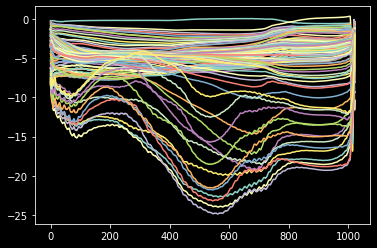

In [15]:
plt.plot(h_mag_dist_pred[0]);

In [16]:
h_freq_true, h_mag_true, h_freq_pred, h_mag_pred = \
    predict.get_freq_and_mag_batch(_model, batch, conf)

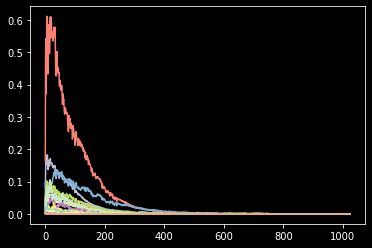

In [17]:
plt.plot(h_mag_true[0]);

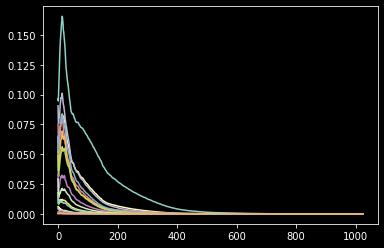

In [18]:
plt.plot(h_mag_pred[0]);

In [19]:
audio_true = predict.reconstruct_audio(h_freq_true, h_mag_true, conf)
audio_pred = predict.reconstruct_audio(h_freq_pred, h_mag_pred, conf)

In [20]:
Audio(audio_true, rate=16000)

In [21]:
Audio(audio_pred, rate=16000)

## Changing Heurisitic Measures

In [27]:
print(heuristic_names)

batch = next(test_iter)

['inharmonicity', 'even_odd', 'sparse_rich', 'attack_rms', 'decay_rms', 'attack_time', 'decay_time', 'bass', 'mid', 'high_mid', 'high']


In [32]:
h_freq_true, h_mag_true, h_freq_pred, h_mag_pred = \
    predict.get_freq_and_mag_batch(_model, batch, conf,
                                   inharmonicity=1)

audio_true = predict.reconstruct_audio(h_freq_true, h_mag_true, conf)
audio_pred = predict.reconstruct_audio(h_freq_pred, h_mag_pred, conf)

Changing value for inharmonicity from 2.35814386542188e-05 to 1.0


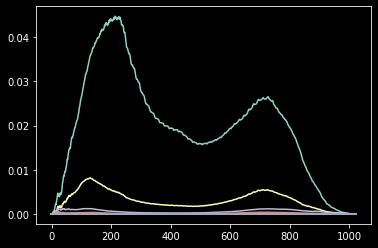

In [33]:
plt.plot(h_mag_pred[0]);

In [34]:
Audio(audio_true, rate=16000)

In [35]:
Audio(audio_pred, rate=16000)

## Export Some Examples


In [4]:
import soundfile as sf


def write_audio(h_freq, h_mag, conf, audio_path):
    audio = predict.reconstruct_audio(h_freq, h_mag, conf)
    audio = np.squeeze(audio.numpy())
    audio = audio / np.max(np.abs(audio))
    sf.write(audio_path, audio, samplerate=conf.sample_rate)


for i in range(0, 20):
    batch = next(test_iter)
    h_freq_true, h_mag_true, h_freq_pred, h_mag_pred = \
        predict.get_freq_and_mag_batch(_model, batch, conf)

    true_path = os.path.join(os.getcwd(), "predictions", f"{i}_true.wav")
    pred_path = os.path.join(os.getcwd(), "predictions", f"{i}_pred.wav")

    write_audio(h_freq_true, h_mag_true, conf, true_path)
    write_audio(h_freq_pred, h_mag_pred, conf, pred_path)

    print(i)

0
1
2


3
4


5


6


7


8


9


10


11
12


13


14


15
16
17
18
19
